In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
import random
from options import DefaultConfig
opt = DefaultConfig()
torch.cuda.set_device(opt.gpu_ids)
torch.manual_seed(opt.seed)
torch.cuda.manual_seed(opt.seed)
torch.cuda.manual_seed_all(opt.seed)
np.random.seed(opt.seed)
random.seed(opt.seed)
import sys
import os
import time
import pdb
from models import create_Inet
import torch
import torchvision
import torchvision.transforms as transforms
from scipy import interpolate
from utils.image_folder import ImageFolder
from utils import utils
from utils.utils import *
# from utils.Visualizer import Visualizer
import matplotlib.pyplot as plt
from IPython.display import clear_output

Interaction Network: initialized


In [3]:
opt.dataroot_val = '/home/zhangy23/dataset/coco_nogray/subval/'
dataset_val = ImageFolder(opt.dataroot_val,
                       transform=transforms.Compose([
                                   transforms.Resize(opt.loadSize),
                                   transforms.RandomCrop(opt.fineSize),
                                   transforms.ToTensor()]))
dataset_loader_val = torch.utils.data.DataLoader(dataset_val, batch_size=opt.batch_size_val, shuffle=False)
dataset_val_size = len(dataset_val)
print('#validation images = %d' % dataset_val_size)

#validation images = 1000


In [4]:
model = create_Inet(opt)
model.setup(opt)
path = './snapshot/test.pkl'
model.load_state_dict(torch.load(path, map_location='cuda:1').state_dict())
model.eval();
model.cuda();

Interaction net is created


/home/zhangy23/anaconda3/envs/vc/lib/python3.6/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'models.interaction_net.Inet' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


TODO:
1. try to train the automatic colourisation first and then interactive
2. try to only use randomcrop
3. stack all the input because some spatial information might lose because of seperation input
4. downsamnpling optimsation in loss calculation

Done:
1. interactive colourisation training without fake_ab using lr: 0.0001
2. change lr to 0.000001
2. add fake_ab and lr is 0.00001

In [5]:
val_loss = 0
val_psnr = 0
for ii, data_raw_val in enumerate(dataset_loader_val):
    # auto colourisartion
    opt.no_prev = True
    #data_raw_val, pp = data_raw_val
    data_cpu_val = utils.get_colorization_data(data_raw_val, opt, p=opt.sample_p)
    if(data_cpu_val is None):
        continue
    data_val = ToCuda(data_cpu_val)
    fake_ab_val = model(data_val['gray'], data_val['clicks'], data_val['prev'])
    prev_ab_val = fake_ab_val.detach().cpu()
    # update first colourisation
    data_cpu_val = utils.get_colorization_data(data_raw_val, opt, prev=prev_ab_val, p=opt.sample_p, num_points = 20)
    # import pdb; pdb.set_trace()
    data_val = ToCuda(data_cpu_val)
    fake_ab_val = model(data_val['gray'], data_val['clicks'], data_val['prev'])
    loss_val = model.calc_loss(data_val['ab'], fake_ab_val)
    psnr_val = calc_batch_psnr(data_val['gray'].detach(), data_val['ab'].detach(), fake_ab_val.detach(), opt, avg=False)

    val_loss += loss_val.detach().cpu().numpy()
    val_psnr += psnr_val
    if ii == 5:
        break
print(val_psnr / dataset_val_size)

/home/zhangy23/anaconda3/envs/vc/lib/python3.6/site-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


1.351426971435547


24.439928408316447
0.9133397381302365


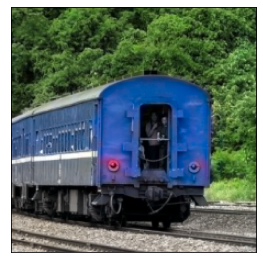

In [8]:
import matplotlib.pyplot as plt 
from skimage.transform import resize
import skimage

lightness = data_val['gray'].cpu()
real_ab = data_val['ab'].cpu()
fake_ab = fake_ab_val.cpu()
fake_img = torch.cat((lightness, fake_ab), 1) 
real_img = torch.cat((lightness, real_ab), 1) 
fake_rgb = lab2rgb(fake_img, opt).detach().numpy()
real_rgb = lab2rgb(real_img, opt).detach().numpy()
idx = 7
img = real_rgb[idx,:,:,:].transpose(1,2,0)
img = fake_rgb[idx,:,:,:].transpose(1,2,0)
img = np.minimum(img, 1)
img = resize(img, (1024, 1024))
skimage.io.imshow(img)
plt.xticks([])
plt.yticks([])
mse = np.mean((fake_rgb[idx, :, :, :] - real_rgb[idx, :, :, :]) ** 2 )
psnr = 10 * np.log10(1.0 / mse)
vif = vifp_mscale(fake_rgb[idx, :, :, :], real_rgb[idx, :, :, :])
print(psnr)
print(vif) 

In [60]:
torch.__version__

'1.4.0'

In [6]:
model.training

False